# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за последние несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — определить параметры, влияющие на цену. Это позволит построить автоматизированную систему, способную отслеживать аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных (расстояние до центра, аэропорта, ближайшего парка и водоёма). 

**Описание данных**:
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах(м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

**План работы**: <a id="plan"></a>
1. [Обзор данных. Первичное исследование данных](#st1)
1. [Предобработка данных](#st2)
1. [Добавление параметров в таблицу](#st3)
1. [Исследовательский анализ данных](#st4)
1. [Исключение редких и выбивающихся значений](#st5)
1. [Исследование зависимости цены от параметров объекта](#st6)
1. [Исследование стоимости на недвижимость по населённым пунктам](#st7)
1. [Исследование объектов в Санкт-Петербурге](#st8)
    - [8.1 Анализ параметров квартир в центральной области Санкт-Петербурга](#st8_1)
    - [8.2 Исследование зависимости цены от других параметров в центральной области Санкт-Петербурга](#st8_2)
1. [Общий вывод](#st9)

### [1. Обзор данных](#plan) <a id="st1"></a> 

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [5]:
realty = pd.read_csv('02_real_estate_data.csv', sep='\t')
print(realty.info())
display(realty.head())
print('Пропущенные значения:')
print(realty.isna().sum())
display(realty.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Пропущенные значения:
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### Обзор данных. Вывод

Всего 23699 записей по 22 колонкам. Сразу бросаются в глаза некоторые проблемы с данными:

#### Проблемы с типами данных:
- Цена на момент снятия с публикации `last_price` может быть целочисленной, а не вещественной.
- Дата публикация объявления `first_day_exposition` имеет тип object, а не datetime.
- Количество этажей в доме `floors_total` - вещественный тип, а не целочисленный.
- Признак `is_apartment` должен иметь булев тип, а не object.
- Число балконов `balcony` должно быть целочисленным, а не вещественным.
- Расстояние до ближайшего аэропорта `airports_nearest` может быть целочисленным, а не вещественным.
- Расстояние до центра города `cityCenters_nearest` может быть целочисленным, а не вещественным.
- Число парков в радусе 3 км `parks_around3000` должно быть целочисленным, а не вещественным.
- Расстояние до ближайшего парка `parks_nearest` может быть целочисленным, а не вещественным.     
- Число водоёмов в радиусе 3 км `ponds_around3000` должно быть целочисленным, а не вещественным.
- Расстояние до ближайшего водоёма `ponds_nearest` может быть целочисленным, а не вещественным.
- Количество дней от публикации до снятия объявления `days_exposition` должно быть целочисленным, а не вещественным.

#### Пропущенные значения:
- Высота потолков `ceiling_height` не заполнена почти в 40% объявлений. Возможно, пользователи посчитали эту информацию неважной, т.к. высота потолка была стандартной, или же они просто не знали этот параметр при размещении объявления.
- Количество этажей в доме `floors_total` не заполнено в 86 объявлениях.
- Жилая площать `living_area` не заполнена в 8% объявлений - нужно будет посмотреть повнимательней, т.к. параметр важный.
- Признак `is_apartment` пропущен в 88% объявлений Вероятно, дело в типе данных, и все эти пропуски по сути - false - указывают на то, что объекты не являются апартаментами.
- Площадь кухни `kitchen_area` не указана почти в 10% объявлений. Нужно посмотреть внимательнее. Возможно, площадь кухни не указана в апартаментах или студиях, т.е. у объектов без отдельной кухни.
- Число балконов `balcony` пропущено почти в половине объявлений. Вероятно, пропуск означает, что балконов в объекте нет.
- Название населённого пункта `locality_name` пропущено в 49 объявлениях. В принципе, немного, но нужно посмотреть внимательнее.
- Расстояние до ближайшего аэропорта `airports_nearest` не указано в 23% объявлений. Вероятно, возникла какая-то проблема с автоматическим заполнением.
- Расстояние до центра города `cityCenters_nearest` не заполнено в 23% объявлений. Та же проблема с картографическими данными и атозаполнением.
- Число парков в радиусе 3 км `parks_around3000` не заполнено в 23% объявлений. Опять та же доля. Проверим, но, скорее всего, это одни и те же объекты.
- Расстояние до ближайшего парка `parks_nearest` не заполнено в 66% объявлений. Может быть, поблизости и вовсе нет парка. Плюс известная проблема с автозаполнением.
- Число водоёмов в радиусе 3 км `ponds_around3000` не заполнено в 23% объявлений. Вероятно, та же проблема с картографическими данными.
- Расстояние до ближайшего водоёма `ponds_nearest` не заполнено в 60% объявлений. Либо поблизости нет водоёма, либо снова проблемы с автозаполнением.
- Количество дней от публикации до снятия объявления `days_exposition` не заполнено в 13% объявлений. Возможно, эти объявления были не закрыты на момент выгрузки данных.

### [2. Предобработка данных](#plan) <a id="st2"></a> 

In [6]:
# Заменим пропуски в колонке с балконами на 0 и изменим тип данных на int:
realty['balcony'] = realty['balcony'].fillna(0).astype('uint8') # максимум балконов в базе 5, так что нам точно достаточно unit8

# Заменим тип данных last_price на int:
realty['last_price'] = realty['last_price'].astype('int64')

Для начала обработаем поля, не вызывающие вопросов. Если пользователь не указал количество балконов `balcony` в квартире, вероятнее всего, их попросту нет.
Цену `last_price` экономнее хранить в целых числах. Копейки роли не играют.

In [7]:
# Удалим строки с пропущенными значениями floors_total (благо, их всего 86) и изменим его на int:
realty.dropna(subset = ['floors_total'], inplace = True)
realty['floors_total'] = realty['floors_total'].astype('uint8')

# Заполним пропуски в высоте потолков ceiling_height.
# Сгруппируем дома по количеству этажей и населённому пункту и вычислим медианную высоту потолка:
ceiling_h_dictionary = realty.groupby(['floors_total', 'locality_name'])['ceiling_height'].median()

#display(ceiling_h_dictionary)
#display(ceiling_h_dictionary[35, 'Санкт-Петербург'])

print('Не указана высота потолка (до заполнения медианой по дому и городу):', realty['ceiling_height'].isna().sum()) # 9118

for index, row in realty.iterrows():
    if np.isnan(row['ceiling_height']) and pd.notna(row['locality_name']): # Если высота пустая и указан населённый пункт 
        height = ceiling_h_dictionary[row['floors_total'], row['locality_name']]
        if pd.notna(height): # Если в справочнике нашлось значение
            realty.loc[index,'ceiling_height'] = height

print('Не указана высота потолка (после заполнения):', realty['ceiling_height'].isna().sum()) # 426

#display(realty[realty['ceiling_height'].isna()])
# Для оставшихся незаполненных значений либо отсутствует информация в справочнике, либо не указан населённый пункт
# Заполним их медианой, рассчитанной по всему столбцу:
realty.loc[realty['ceiling_height'].isna(), 'ceiling_height'] = realty['ceiling_height'].median()
print('Не указана высота потолка (после заполнения медианой по всему столбцу):',realty['ceiling_height'].isna().sum()) # 0

Не указана высота потолка (до заполнения медианой по дому и городу): 9118
Не указана высота потолка (после заполнения): 426
Не указана высота потолка (после заполнения медианой по всему столбцу): 0


Пропущенные значения высоты потолка `ceiling_height` обработали следующим образом: 
- сгруппировали данные по населённому пункту и количеству этажей в доме
- вычислили медианное значение высоты потолка для домов разной этажности в разных населённых пунктах
- заполнили пропуски получившимися медианными значениями, которые нашлись в справочнике
- оставшиеся 426 пропусков заполнили медианой по всему столбцу 

In [8]:
# Изменим тип данных поля first_day_exposition на datetime
try:
    realty['first_day_exposition']= pd.to_datetime(realty['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
except:
    print('Проверьте корректность данных в столбце "first_day_exposition"')    

In [9]:
# Приведём поле 'is_apartment' к логическому типу данных. Заполним пропуски нулями, чтобы они не превратились в True:
realty['is_apartment'] = realty['is_apartment'].fillna(0).astype('bool') 

Корреляция жилой и общей площади: 0.9397704889780091
Корреляция жилой площади и числа комнат: 0.8460058343889169
Корреляция жилой площади и площади кухни: 0.42876823765222927
Количество пропусков living_area до заполнения: 1870
Количество пропусков living_area после заполнения: 0


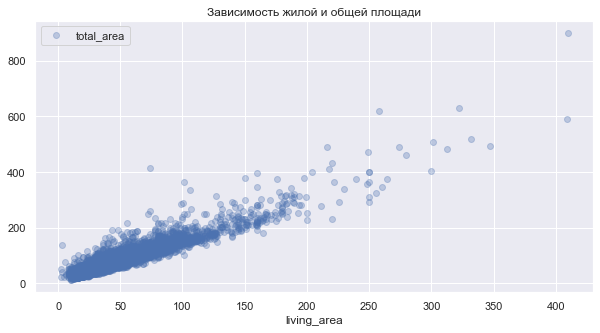

In [10]:
# Заполним поле 'living_area'
# Посмотрим коэффициенты корреляции жилой площади и других параметров по квартире:
print('Корреляция жилой и общей площади:', realty['living_area'].corr(realty['total_area'])) # 0.9
print('Корреляция жилой площади и числа комнат:', realty['living_area'].corr(realty['rooms'])) # 0.8
print('Корреляция жилой площади и площади кухни:', realty['living_area'].corr(realty['kitchen_area'])) # 0.4

# Очевидна связь жилой и общей площади квартиры:
realty.plot(x='living_area', y='total_area', figsize=(10,5), grid=True, style='o', alpha=0.3, title='Зависимость жилой и общей площади')

# ВЫЧИСЛИМ МЕДИАННУЮ ДОЛЮ ЖИЛОЙ ПЛОЩАДИ В КВАРТИРЕ
def living_segment(row):
# Функция принимает на вход строку и вычисляет долю жилой площади в объекте. 
# Если жилая площадь в объявлении не указана, запись не обрабатывается. Т.е. доля не определена - NaN 
    if row['living_area']:
        return row['living_area'] / row['total_area']

# Добавим в таблицу соотношение жилой и общей площади:    
realty['living_segment'] = realty.apply(living_segment, axis=1)

# Заполним пропущенные значения 'living_area' медианой по новому столбцу:
print('Количество пропусков living_area до заполнения:', realty['living_area'].isna().sum()) # 1870
ls_median = realty['living_segment'].median()
realty.loc[realty['living_area'].isna(), 'living_area'] = realty['total_area'] * ls_median
print('Количество пропусков living_area после заполнения:', realty['living_area'].isna().sum()) # 0

Пропуски в жилой площади `living_area` заполнили с на основе средней доли жилой площади в общей площади квартиры (медиана по всей базе).

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_segment
total_images,1.000000,0.104940,0.116425,0.099385,0.003954,0.010427,0.102501,0.033286,0.010423,-0.028116,-0.024607,0.105773,0.047212,-0.002632,-0.047935,0.020989,-0.006209,-0.011154,-0.003601,-0.026578,-0.000390
last_price,0.104940,1.000000,0.653581,0.363124,0.071190,-0.006984,0.585614,0.026644,0.026974,-0.025083,-0.008801,0.520018,0.008598,-0.026098,-0.206213,0.151657,-0.016633,0.160479,-0.085450,0.081063,0.002762
total_area,0.116425,0.653581,1.000000,0.758324,0.089602,-0.075774,0.946146,-0.024927,0.029702,-0.071983,-0.034941,0.609468,0.010104,-0.030124,-0.230872,0.166048,-0.021394,0.163245,-0.099495,0.150130,0.143352
rooms,0.099385,0.363124,0.758324,1.000000,0.051093,-0.228215,0.827340,-0.151586,0.000378,-0.145983,-0.087687,0.269672,-0.015759,-0.061269,-0.184750,0.138306,-0.054034,0.093411,-0.059096,0.127470,0.482015
ceiling_height,0.003954,0.071190,0.089602,0.051093,1.000000,-0.018929,0.087089,-0.006754,0.144945,0.001518,0.018922,0.082701,0.027539,-0.022451,-0.090134,0.061382,-0.020210,0.074011,-0.052629,0.018884,0.007356
floors_total,0.010427,-0.006984,-0.075774,-0.228215,-0.018929,1.000000,-0.159539,0.678059,-0.026351,0.070151,0.050791,0.163944,0.172812,0.108288,0.019774,-0.252833,0.097527,-0.122735,0.038864,-0.052234,-0.366147
living_area,0.102501,0.585614,0.946146,0.827340,0.087089,-0.159539,1.000000,-0.089388,0.028726,-0.055753,-0.024879,0.436210,-0.010661,-0.051617,-0.228908,0.179996,-0.049307,0.148923,-0.085615,0.144193,0.419165
floor,0.033286,0.026644,-0.024927,-0.151586,-0.006754,0.678059,-0.089388,1.000000,-0.013208,0.035908,0.036140,0.135486,0.171005,0.072878,0.008963,-0.163942,0.072874,-0.076067,0.025381,-0.039018,-0.264147
is_apartment,0.010423,0.026974,0.029702,0.000378,0.144945,-0.026351,0.028726,-0.013208,1.000000,-0.003633,-0.002457,0.049127,0.032952,0.016532,0.003772,0.020806,-0.033541,0.024028,0.003317,0.015294,0.002008
studio,-0.028116,-0.025083,-0.071983,-0.145983,0.001518,0.070151,-0.055753,0.035908,-0.003633,1.000000,-0.004208,NaN,0.030050,-0.021643,-0.006793,-0.030808,0.006925,0.000765,0.001858,-0.021604,0.088813


Количество пропусков kitchen_area до заполнения: 2231
Количество пропусков kitchen_area после заполнения: 0


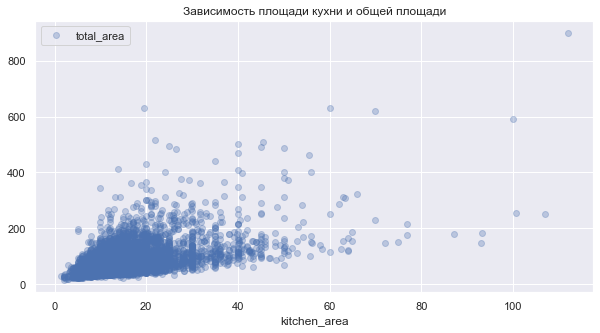

In [11]:
# Заполним поле 'kitchen_area'
# Рассмотрим коэффициенты корреляции площади кухни и других параметров по квартире:
display(realty.corr())

# Самая сильная связь 'kitchen_area' наблюдается с общей площадью квартиры:
realty.plot(x='kitchen_area', y='total_area', figsize=(10,5), grid=True, style='o', alpha=0.3, title='Зависимость площади кухни и общей площади')

# ВЫЧИСЛИМ МЕДИАННУЮ ДОЛЮ ПЛОЩАДИ КУХНИ В КВАРТИРЕ
def kitchen_segment(row):
# Функция принимает на вход строку и вычисляет долю кухни в общей площади объекте. 
# Если площадь кухни в объявлении не указана, запись не обрабатывается. Т.е. доля не определена - NaN 
    if row['kitchen_area']:
        return row['kitchen_area'] / row['total_area']

# Добавим в таблицу отношение площади кухни к общей площади:
realty['kitchen_segment'] = realty.apply(kitchen_segment, axis=1)  

# Заполним пропущенные значения 'kitchen_area' медианой по новому столбцу:
print('Количество пропусков kitchen_area до заполнения:', realty['kitchen_area'].isna().sum()) # 1870
ks_median = realty['kitchen_segment'].median()
realty.loc[realty['kitchen_area'].isna(), 'kitchen_area'] = realty['total_area'] * ks_median
print('Количество пропусков kitchen_area после заполнения:', realty['kitchen_area'].isna().sum()) # 0 

Пропуски в площади кухни 'kitchen_area' заполнили с помощью доли площади кухни в общей площади квартиры (медиана по всей базе).

In [12]:
# Посмотрим на пропуски в полях, заполненных автоматически на основе картографических данных:
print('Объекты с пропусками в полях, заполненных на основе картографических данных:', len(realty[realty['cityCenters_nearest'].isna() & realty['parks_around3000'].isna() & realty['ponds_around3000'].isna()]))
# 23% объявлений остались без картографических оценок - вероятно, произошла какая-то ошибка при размещении или выгрузке

# Посмотрим внимательнее на населённые пункты, по которым нет картографических оценок:
locality_without_data = realty[realty['cityCenters_nearest'].isna() & realty['parks_around3000'].isna() & realty['ponds_around3000'].isna()]['locality_name'].unique()
# Населённые пункты, в которых встречаются объекты с заполненными полями:
locality_with_data = realty[~(realty['cityCenters_nearest'].isna() & realty['parks_around3000'].isna() & realty['ponds_around3000'].isna())]['locality_name'].unique()
display('Нет оценок на основе картографических данных:', locality_without_data)
display('Есть оценки на основе картографических данных:', locality_with_data)

lacality_superpos = []
for element in locality_without_data:
    if element in locality_with_data: 
        lacality_superpos.append(element)
display('Пересечение:', lacality_superpos)

Объекты с пропусками в полях, заполненных на основе картографических данных: 5508


'Нет оценок на основе картографических данных:'

array(['городской посёлок Янино-1', 'посёлок Мурино', 'Сертолово',
       'деревня Кудрово', 'Коммунар',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кировск',
       'деревня Новое Девяткино', 'Санкт-Петербург',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'деревня Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Сясьстрой', 'деревня Старая', 'деревня Лесколово',
       'посёлок Новый Свет', 'Сланцы', 'село Путилово', 'Ивангород',
       'Мурино', 'Шлиссельбург', 'Никольское', 'Сосновый Бор',
       'поселок Новый Свет', 'деревня Оржицы', 'деревня Кальтино',
 

'Есть оценки на основе картографических данных:'

array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Парголово',
       'Ломоносов', 'Петергоф', 'Пушкин', 'Колпино', 'Кронштадт',
       'посёлок Металлострой', 'Павловск', 'Сестрорецк', 'Красное Село',
       'посёлок Понтонный', 'Зеленогорск', 'посёлок Молодёжное',
       'посёлок Стрельна', 'посёлок Александровская', nan,
       'посёлок Песочный', 'посёлок Петро-Славянка', 'посёлок Репино',
       'посёлок Сапёрный', 'поселок Лисий Нос', 'посёлок Левашово',
       'посёлок Белоостров', 'посёлок Лисий Нос', 'посёлок Усть-Ижора'],
      dtype=object)

'Пересечение:'

['Санкт-Петербург',
 'посёлок Шушары',
 'Красное Село',
 'Ломоносов',
 'Кронштадт',
 'Колпино']

Очевидно, что система автоматической оценки расстояний работает несовершенно, особенно в небольших населённых пунктах. 

Учитывая, что наши данные в дальнейшем будут исследованы НЕ чувствительным к пропускам алгоритмом (корреляцией), оставим эти пропуски без изменений.

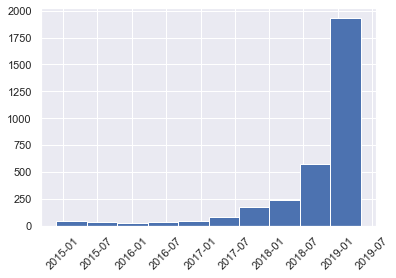

In [13]:
# Рассмотрим пропуски в поле 'days_exposition' (количество дней от публикации до снятия объявления):
realty[realty['days_exposition'].isna()]['first_day_exposition'].hist(xrot=45)
plt.show()

Чем позже было размещено объявление, тем больше вероятность, что поле `days_exposition` не заполнено. Очевидно, что объявления с пропущенными значениями в `days_exposition` на момент выгрузки были ещё актуальны. 
Оставим эти пропуски, как есть.

In [16]:
print('Дубликатов:', realty.duplicated().sum()) # 0 - дубликатов нет
print(realty.info())

Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  int64         
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  uint8         
 7   living_area           23613 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          23613 non-null  float64       
 13  ba

### Предобработка данных. Вывод
#### Обработка пропущенных значений:
- Пропущенные значения в количестве балконов `balcony` заменили на нули.
- Строки с пропусками в `floors_total` удалили, чтобы поменять тип данного поля на целочисленный и сэкономить память. Благо таких записей ничтожно мало.
- Пропущенные значения высоты потолка `ceiling_height` заполнили на основе группировки домов по количеству этажей и населённому пункту с вычислинием медианы высоты потолка по каждой группе.
- Пропущенные значения в жилой площади `living_area` вычислили на основе доли жилой площади в общей площади квартиры по всей базе.
- Пропущенные значения в площади кухни `kitchen_area` вычислили на основе доли площади кухни в общей площади квартиры по всей базе.
- Пропуски в автоматически полученных картографических данных проигнорировали, т.к. алгоритм предстоящего анализа не чувствителен к NaN'ам. 
- Пропущенные значения в названии населённого пункта `locality_name` ничем заменить не получится.
- Пропущенные значения в количестве дней от публикации до снятия объявления `days_exposition`, вероятно, означают, что объявления были актуальны (не сняты) на момент выгрузки данных. Оставили их, как есть, чтобы не портить статистику.

#### Обработка типов данных:
- Везде, где можно, привели поле к типу int: `balcony`, `last_price`, `floors_total`.
- Заменили тип данных поля `is_apartment` на логический.
- Заменили тип данных поля `first_day_exposition` на datetime.

### [3. Добавление параметров в таблицу](#plan) <a id="st3"></a> 

In [17]:
# Добавим в таблицу столбец с ценой квадратного метра:
def m_price(row):
    price = (row['last_price'] / row['total_area'])
    return price

realty['price_per_meter'] = realty.apply(m_price, axis=1).astype('int64')

# Добавим в таблицу день недели, месяц и год публикации объявления:
realty['weekday'] = realty['first_day_exposition'].dt.weekday
realty['month'] = realty['first_day_exposition'].dt.month
realty['year'] = realty['first_day_exposition'].dt.year

# Добавим в таблицу признак расположения этажа, на котором находится объект:
def floor_location(row):
    if row['floor'] == 1: return 'первый'
    if row['floor'] == row['floors_total']: return 'последний'
    else: return 'другой'

realty['floor_location'] = realty.apply(floor_location, axis=1)

# Долю жилой площади и долю кухни добавили ранее, когда заполняли пропуски в соответствующих площадях

display(realty[['price_per_meter', 'floor_location', 'total_area', 'living_area', 'kitchen_area', 'living_segment', 'kitchen_segment', 'first_day_exposition', 'year', 'month', 'weekday']].head(10))

,price_per_meter,floor_location,total_area,living_area,kitchen_area,living_segment,kitchen_segment,first_day_exposition,year,month,weekday
0,120370,другой,108.00,51.000000,25.000000,0.472222,0.231481,2019-03-07,2019,3,3
1,82920,первый,40.40,18.600000,11.000000,0.460396,0.272277,2018-12-04,2018,12,1
2,92785,другой,56.00,34.300000,8.300000,0.612500,0.148214,2015-08-20,2015,8,3
3,408176,другой,159.00,90.340909,27.403282,NaN,NaN,2015-07-24,2015,7,4
4,100000,другой,100.00,32.000000,41.000000,0.320000,0.410000,2018-06-19,2018,6,1
5,95065,другой,30.40,14.400000,9.100000,0.473684,0.299342,2018-09-10,2018,9,0
6,99195,другой,37.30,10.600000,14.400000,0.284182,0.386059,2017-11-02,2017,11,3
7,110544,другой,71.60,40.681818,18.900000,NaN,0.263966,2019-04-18,2019,4,3
8,87454,другой,33.16,15.430000,8.810000,0.465320,0.265682,2018-05-23,2018,5,2
9,88524,другой,61.00,43.600000,6.500000,0.714754,0.106557,2017-02-26,2017,2,6


### Добавление параметров в таблицу. Вывод
Вычислили и добавили в таблицу необходимые для дальнейших исследований параметры: цена за квадратный метр, расположение этажа в доме, доля жилой площади, доля кухни.

### [4. Исследовательский анализ данных](#plan) <a id="st4"></a> 

In [18]:
def hist_display(df, param, title):
# Функция выводит описание describe() колонки df[param] и строит для неё гистограмму с заголовком title
    d = df[param].describe()
    display(d)
    r1 = d['25%'] - 3 * (d['75%'] - d['25%'])
    r2 = d['25%'] + 5 * (d['75%'] - d['25%'])
    if r1 < 0: r1 = 0 # Отрицательных значений у нас нет - выше смотрели describe() по базе
    df[param].plot(kind='hist', bins=30, range=(r1, r2), grid=True, title=title, figsize=(10,5), legend=True)

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

Объекты с общей площадью менее 20 или более 200 метров: 1.07%


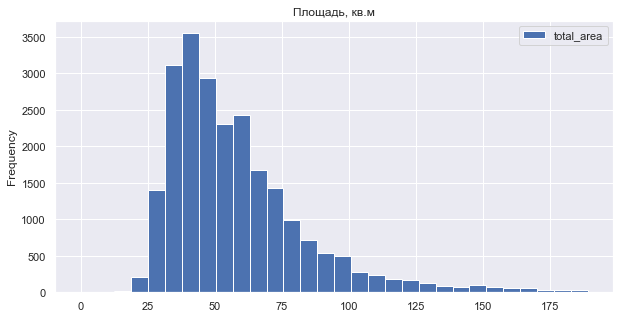

In [19]:
# Изучим данные о площади квартир:
hist_display(realty, 'total_area', 'Площадь, кв.м')
print('Объекты с общей площадью менее 20 или более 200 метров: {:.2%}'.format(realty.query('total_area > 200 or total_area < 20')['total_area'].count() / len(realty)))

Средняя площадь объектов по всей базе ~60 кв.м., медиана 52 кв.м. Большинство объектов имеют площадь от 20м до 150м.

count    2.361300e+04
mean     6.540555e+06
std      1.090172e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Объекты с ценой более 20 млн: 2.99%


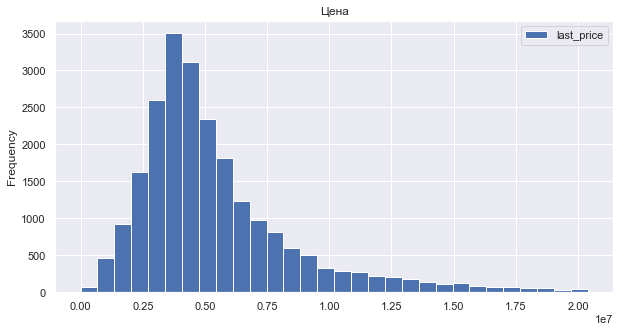

In [20]:
# Изучим данные о стоимости объектов:
hist_display(realty, 'last_price', 'Цена')

print('Объекты с ценой более 20 млн: {:.2%}'.format(realty.query('last_price > 20000000')['last_price'].count() / len(realty)))

Средняя стоимость квартиры около 6.5 млн, медиана - 4.5 млн.
Только 3% объектов имеют цену более 20 млн рублей.

count    23613.000000
mean         2.071147
std          1.078380
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Объекты с количеством комнат более 4-x: 2.20%


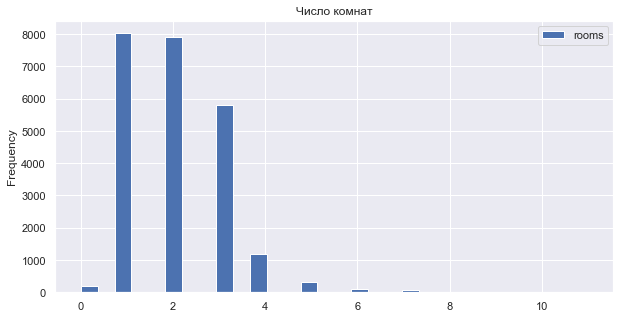

In [21]:
# Изучим данные о количестве комнат:
hist_display(realty, 'rooms', 'Число комнат')

print('Объекты с количеством комнат более 4-x: {:.2%}'.format(realty.query('rooms > 4')['last_price'].count() / len(realty)))

Большинство объектов имеют от 1 до 3 комнат. Среднее количество комнат по всей база совпадает с медианой - 2 шт.
В выгрузке всего 2.2% объявлений с количеством комнат более 4-x. 

count    23613.000000
mean         2.737896
std          1.008211
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

Объекты с высотой потолка менее 2.3 или более 3.5 метров: 1.40%


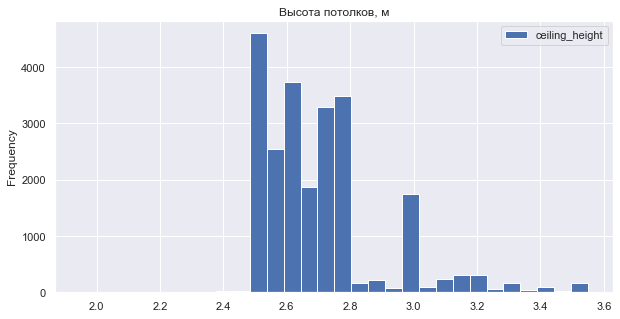

In [22]:
# Изучим данные о высоте потолков:
hist_display(realty, 'ceiling_height', 'Высота потолков, м')

print('Объекты с высотой потолка менее 2.3 или более 3.5 метров: {:.2%}'.format(realty.query('ceiling_height < 2.3 or ceiling_height > 3.5')['ceiling_height'].count() / len(realty)))

Медиана высоты потолка: 2.65м. Только 1.4% объявлений имеют высоту потолка менее 2.3 или более 3.5 метров.

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

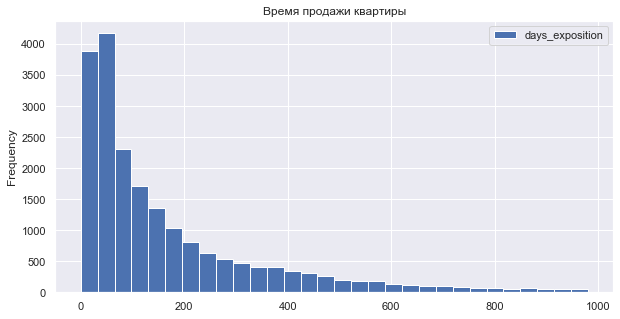

In [23]:
# Рассмотрим время продажи квартиры: 
hist_display(realty, 'days_exposition', 'Время продажи квартиры')

Гистограмма времени продажи квартиры имеет длинный хвост, поэтому среднее значение больше медианного почти в 2 раза.
Опираясь на квартили, можно сказать, что квартира продалась быстро, если сделка закрылась за 45 дней и меньше. И, наоборот, долго, если объявление висело дольше 230 дней. 

### Исследовательский анализ данных. Вывод

Рассмотрели основные параметры недвижимости по всей базе:
- Средняя площадь объектов: ~60 кв.м., медиана: 52 кв.м. Большинство объектов имеют площадь от 20м до 150м.
- Средняя стоимость квартиры: около 6.5 млн, медиана: 4.5 млн. Только 3% объектов имеют цену более 20 млн рублей.
- Большинство объектов имеют от 1 до 3 комнат. Среднее количество комнат по всей база совпадает с медианой - 2 шт. В выгрузке всего 2.2% объявлений с количеством комнат более 4-x.
- Медиана высоты потолка: 2.65м. Только 1.4% объявлений имеют высоту потолка менее 2.3 или более 3.5 метров.
- Гистограмма времени продажи квартиры имеет длинный хвост, поэтому среднее значение больше медианного почти в 2 раза. Опираясь на квартили, можно сказать, что квартира продалась быстро, если сделка закрылась за 45 дней и меньше. И, наоборот, долго, если объявление висело дольше 230 дней.

### [5. Исключение редких и выбивающихся значений](#plan) <a id="st5"></a> 

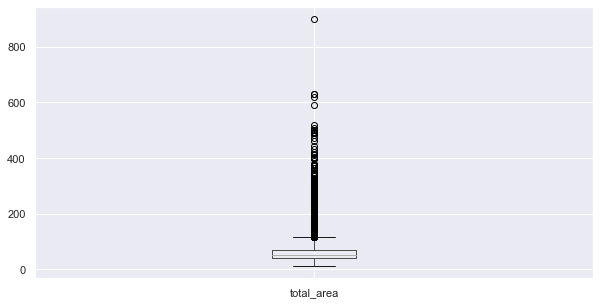

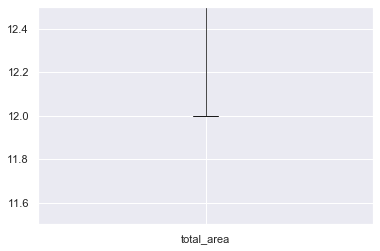

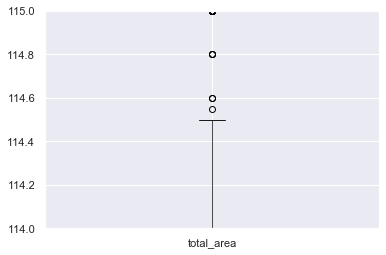

In [24]:
# Построим диаграмму размаха для общей площади объектов total_area:
realty.boxplot(column='total_area', figsize=(10,5))
plt.figure()
plt.ylim(11.5, 12.5)
realty.boxplot(column='total_area', figsize=(10,5)) # total_area >= 12
plt.figure()
plt.ylim(114, 115)
realty.boxplot(column='total_area', figsize=(10,5)) # total_area <= 114.5
plt.show()

Выбросы находятся за чертой в 12 и 115 кв.м.

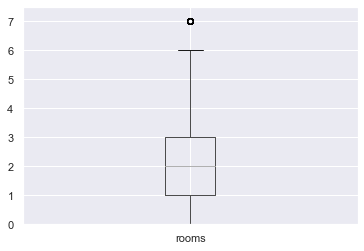

In [25]:
# Построим диаграмму размаха для числа комнат rooms:
plt.ylim(0, 7.5)
realty.boxplot(column='rooms', figsize=(10,5))
plt.show()

Большинство объектов имеют не более 6-ти комнат.

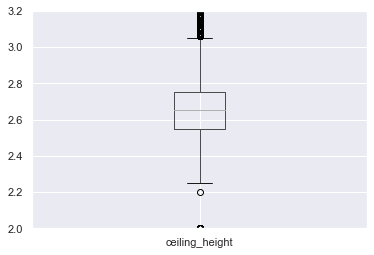

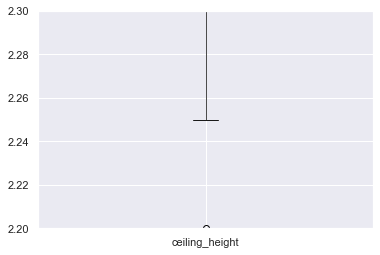

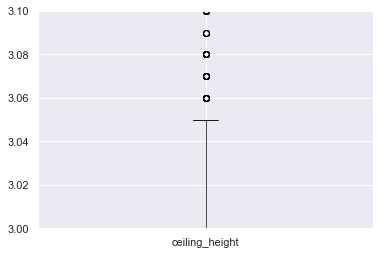

In [26]:
# Построим диаграмму размаха высоты потолка ceiling_height:
plt.ylim(2, 3.2)
realty.boxplot(column='ceiling_height', figsize=(10,5))
plt.figure()
plt.ylim(2.2, 2.3)
realty.boxplot(column='ceiling_height', figsize=(10,5)) # ceiling_height >= 2.25
plt.figure()
plt.ylim(3, 3.1)
realty.boxplot(column='ceiling_height', figsize=(10,5)) # ceiling_height <= 3.05
plt.show()

Большинство объектов имеют высоту потолка от 2.25 до 3.05 метров.

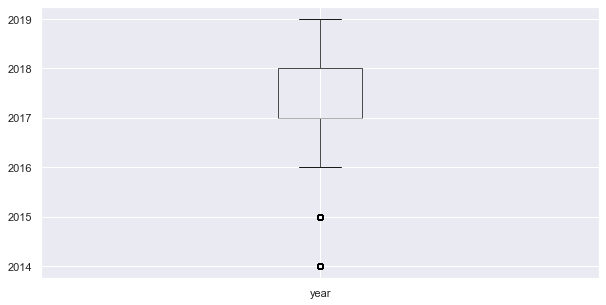

In [27]:
# Построим диаграмму размаха для года размещения объявления year:
realty.boxplot(column='year', figsize=(10,5))
plt.show()

Выбросы размещены ранее 2016г.

In [28]:
# Отфильтруем базу по полученным значениям:
good_data = realty.query('(12 <= total_area <= 114.5) and rooms < 7 and (2.25 <= ceiling_height <= 3.05) and year >= 2016')
print('Количество объектов в базе до исключения выбивающихся значений:', len(realty))
print('Количество объектов в базе после исключения выбивающихся значений:', len(good_data))

Количество объектов в базе до исключения выбивающихся значений: 23613
Количество объектов в базе после исключения выбивающихся значений: 20048


### Исключение редких и выбивающихся значений. Вывод

Убрали из базы редкие и выбивающиеся значения - всего 3565 объявлений:
- объекты площадью менее 12 или более 114.5 кв.м.
- объекты с количеством комнат более 6-ти.
- объекты с высотой потолка менее 2.25 или более 3.05 м.
- объекты, размещённые в базе ранее 2016 года.

### [6. Исследование зависимости цены от других параметров](#plan) <a id="st6"></a> 

In [29]:
"""
Функция строит график зависимости цены 'last_price' от входного параметра 'param', 
а также вычисляет для них коэффициент корреляции Пирсона.
Входные параметры:
    df - DataFrame
    param - параметр, по которому проверяется связь с 'last_price'
    style - стиль построения графика df.plot()
    alpha - прозрачность линии графика df.plot()
    ylim - минимальное значение оси ординат графика df.plot()
    title - название графика 
"""
def price_relation(df, param, style, alpha, ylim, title):
    (df
     .pivot_table(index=param, values='last_price', aggfunc='median')
     .plot(grid=True, style=style, title=title, ylim=ylim, figsize=(10, 5), alpha=alpha)
    )
    try:
        print('Коэффициент корреляции Пирсона:', df['last_price'].corr(df[param]))
    except:
        print('price_relation: Коэффициент корреляции Пирсона вычислить не удалось')

Коэффициент корреляции Пирсона: 0.6890427340412627


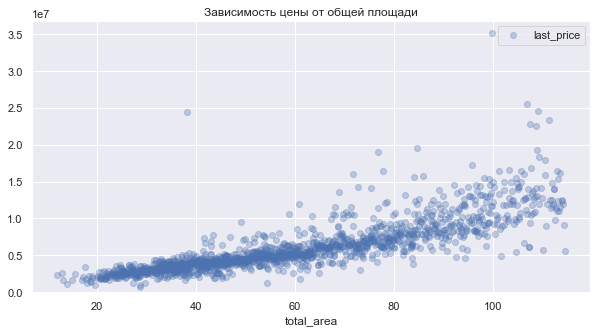

In [31]:
# Рассмотрим зависимость цены от общей площади квартиры:
price_relation(good_data, 'total_area', 'o', 0.3, 0, 'Зависимость цены от общей площади')


# Рассмотрим поближе выдающиеся пики:
# display(good_data['cityCenters_nearest'].describe())
# (display(good_data.query('(total_area < 40 and last_price > 20000000) or (95 < total_area < 100 and last_price > 35000000)')
#       [['last_price' , 'total_area', 'cityCenters_nearest', 'ceiling_height']])
# )
# display(good_data.loc[21238])

Цена в целом прямо зависит от площади. Большой разброс наблюдается в правой части графика, где оказались "нестандартные" объекты с большой площадью. На данном участке нужно внимательнее смотреть на другие факторы.

Коэффициент корреляции Пирсона также указывает на наличие зависимости цены от площади (0.69).

Выброс площадью около 100 метров оказался расположен близко к центру города, что, вероятно, и повлияло на стоимость.
А вот выбивающееся значение площадью около 40 м объяснить трудно - г. Всеволжск, однокомнатная ничем не примечательная квартира - подозрительный объект.

Коэффициент корреляции Пирсона: 0.3869457014003367


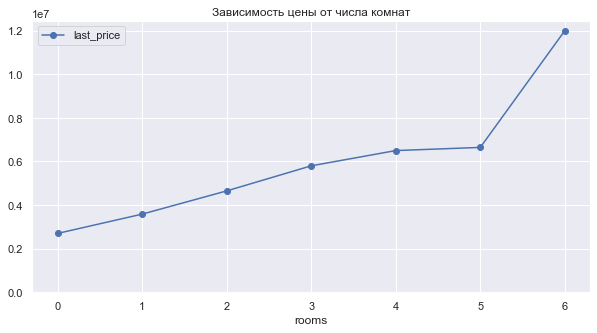

In [32]:
# Рассмотрим зависимость цены от количества комнат:
price_relation(good_data, 'rooms', 'o-', 1, 0,'Зависимость цены от числа комнат')

До трёх комнат включительно зависимость чёткая - чем больше жилых помещений, тем выше цена. Однако, далее, для больших многокомнатных объектов (3-4 и более комнат) эта связь пропадает.

Коэффициент корреляции 0.39 свидетельствует об отсутствии связи между количеством комнат и ценой по всей базе в целом.

Коэффициент корреляции Пирсона: -0.3143302315484106


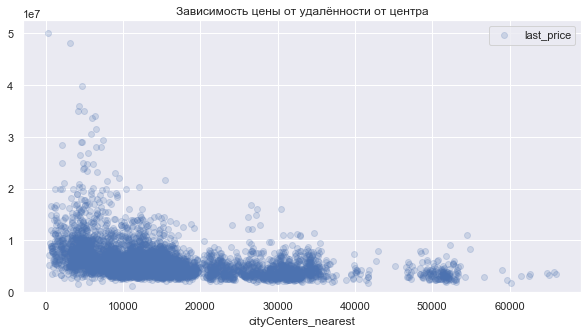

In [33]:
# Рассмотрим зависимость цены от удалённости от центра:
price_relation(good_data, 'cityCenters_nearest', 'o', 0.2, 0,'Зависимость цены от удалённости от центра')

Высокие цены на квартиры чаще встречаются ближе к центру. Однако, нельзя сказать, что цена каким-то образом зависит от расстояния до центра.
Коэффициент корреляции Пирсона подтверждает отсутствие зависимости цены от близости к центру (-0.31)

price_relation: Коэффициент корреляции Пирсона вычислить не удалось
Коэффициент корреляции Пирсона по всем этажам: 0.13798226343921738


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_segment,kitchen_segment,price_per_meter,weekday,month,year,floor_location,floor_location_int
18473,4,4140000,48.8,2017-07-18,1,2.70,18,18.5,16,False,False,False,20.0,0,Санкт-Петербург,51480.0,17018.0,0.0,NaN,0.0,NaN,30.0,0.379098,0.409836,84836,1,7,2017,другой,2
22425,12,5890000,74.0,2017-10-14,4,2.55,9,50.0,5,False,False,False,7.0,0,Санкт-Петербург,49910.0,16109.0,1.0,480.0,0.0,NaN,27.0,0.675676,0.094595,79594,5,10,2017,другой,2
15296,7,4950000,53.0,2018-07-10,2,2.50,9,33.0,9,False,False,False,6.8,0,Санкт-Петербург,41954.0,12168.0,1.0,10.0,0.0,NaN,62.0,0.622642,0.128302,93396,1,7,2018,последний,3
7877,12,8700000,64.5,2018-12-15,2,2.70,17,34.5,12,False,False,False,13.1,0,Санкт-Петербург,30139.0,11004.0,1.0,379.0,0.0,NaN,75.0,0.534884,0.203101,134883,5,12,2018,другой,2
3353,16,3150000,36.0,2016-05-24,1,2.70,24,17.0,7,False,False,False,10.0,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,497.0,0.472222,0.277778,87500,1,5,2016,другой,2
4828,2,3890000,69.2,2018-10-01,2,2.75,19,43.9,19,False,False,False,9.0,0,Санкт-Петербург,34618.0,15186.0,0.0,NaN,0.0,NaN,36.0,0.634393,0.130058,56213,0,10,2018,последний,3
17723,16,5980000,52.0,2018-04-28,1,3.00,26,30.0,25,False,False,False,14.0,0,Санкт-Петербург,40648.0,9888.0,1.0,1248.0,0.0,NaN,306.0,0.576923,0.269231,115000,5,4,2018,другой,2
6727,2,20000000,110.6,2019-03-20,4,2.95,7,78.4,4,False,False,False,8.8,0,Санкт-Петербург,11073.0,10422.0,2.0,173.0,0.0,NaN,NaN,0.708861,0.079566,180831,2,3,2019,другой,2
5795,12,2900000,30.5,2017-10-18,1,2.65,5,16.0,3,False,False,False,6.5,0,Санкт-Петербург,23556.0,16170.0,0.0,NaN,0.0,NaN,97.0,0.524590,0.213115,95081,2,10,2017,другой,2
9589,20,5500000,50.0,2018-07-01,2,2.75,5,32.0,3,False,False,False,6.0,0,Санкт-Петербург,23205.0,4840.0,1.0,17.0,0.0,NaN,22.0,0.640000,0.120000,110000,6,7,2018,другой,2


Коэффициент корреляции Пирсона по группам этажей: 0.030398799830651142


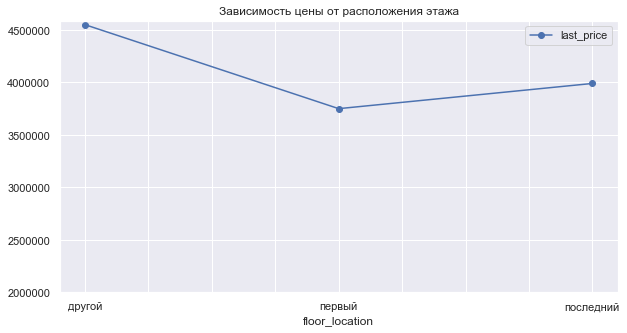

In [34]:
# Рассмотрим зависимость цены от расположения этажа:
price_relation(good_data, 'floor_location', 'o-', 1, 2000000,'Зависимость цены от расположения этажа')

print('Коэффициент корреляции Пирсона по всем этажам:', good_data['floor'].corr(good_data['last_price']))
# Для расчёта коэффициента корреляции по группам этажей, добавим в таблицу числовой признак расположения этажа, на котором находится объект:
def floor_location_int(row):
    if row['floor'] == 1: return 1 # первый этаж
    if row['floor'] == row['floors_total']: return 3 # последний этаж
    else: return 2 # другой этаж

good_data['floor_location_int'] = good_data.apply(floor_location_int, axis=1)
display(good_data.sample(10))
print('Коэффициент корреляции Пирсона по группам этажей:', good_data['floor_location_int'].corr(good_data['last_price']))

Цена не зависит от этажа, на котором находится квартира. 

Коэффициент корреляции Пирсона: -0.014065484968642537


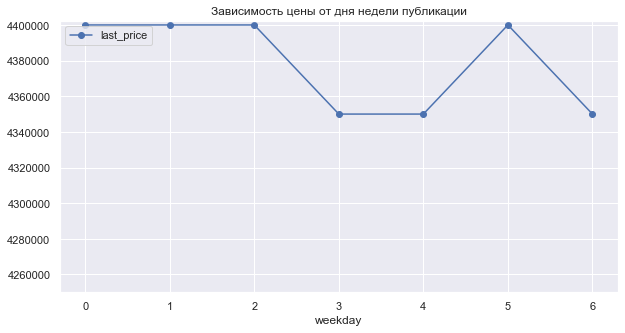

In [35]:
# Рассмотрим зависимость цены от даты размещения (дня недели):
price_relation(good_data, 'weekday', 'o-', 1, 4250000,'Зависимость цены от дня недели публикации')

Цена не зависит от дня недели публикации объявления.

Коэффициент корреляции Пирсона: -0.00433307241507655


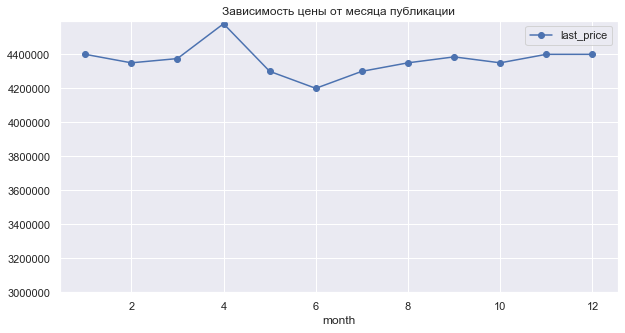

In [36]:
# Рассмотрим зависимость цены от даты размещения (месяца):
price_relation(good_data, 'month', 'o-', 1, 3000000,'Зависимость цены от месяца публикации')

Цена не зависит от месяца публикации объявления.

Коэффициент корреляции Пирсона: 0.027609179303509486


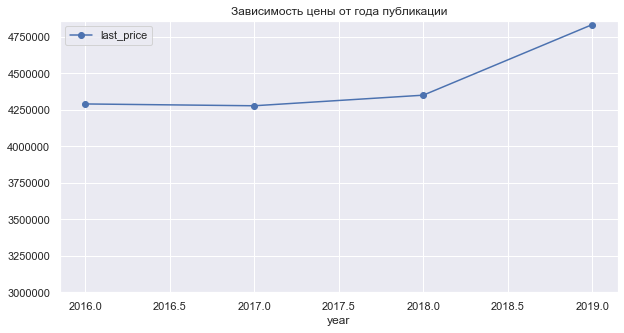

In [37]:
# Рассмотрим зависимость цены от даты размещения (года):
price_relation(good_data, 'year', 'o-', 1, 3000000,'Зависимость цены от года публикации')

В нашей базе слишком маленький разброс лет, чтобы делать какие-то выводы. Связь года публикации объявления с ценой пока не  прослеживается.

### Исследование зависимости цены от других параметров. Вывод

1. Установлена зависимость цены от общей площади объекта (коэфф. корреляции: 0.68). При этом существенный разброс наблюдается среди квартир с большой площадью.
2. Связь цены с количеством комнат не сильна (коэфф. корреляции: 0.39). Коэффициент положительный, т.е. при увеличении числа комнат стоимость в целом растёт, но зависимость слабая.
3. Связь цены с удалённостью объекта от центра для всей базы в целом не обнаружена (коэфф. корреляции: -0.31).
4. Связь цены с этажом, на котором находится квартира, так же не обнаружена (коэфф. корреляции: 0.13).
5. Цена так же не зависит от даты публикации объявления - ни от дня недели (коэфф. корр.: -0.01), ни от месяца (коэфф. корр: -0.004), ни от года (коэфф. корр.: 0.02)

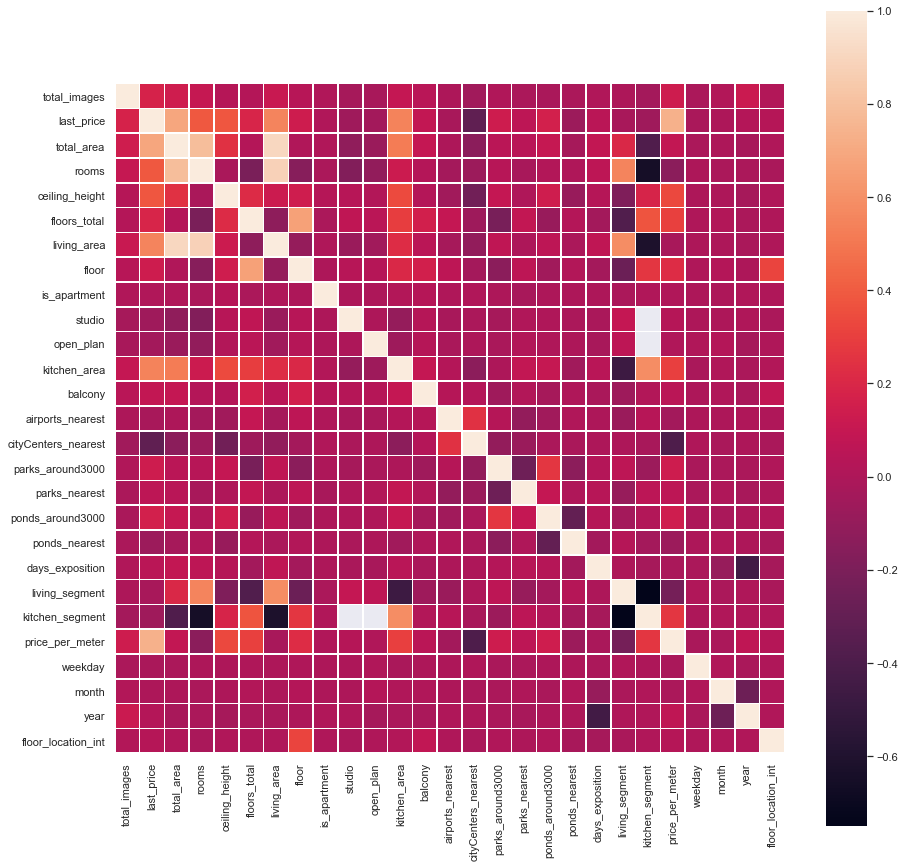

In [39]:
fig, ax = plt.subplots(figsize=(15,15))     
sns.heatmap(good_data.corr(), linewidths=.5, square=True)
plt.show()

### [7. Исследование стоимости на недвижимость по населённым пунктам](#plan) <a id="st7"></a> 

,locality_name,count,median_price_per_m
0,Санкт-Петербург,12705,103426.0
6,Пушкин,312,99697.0
8,деревня Кудрово,275,92152.0
4,посёлок Парголово,314,91579.0
1,посёлок Мурино,506,86171.0
2,посёлок Шушары,424,76876.0
5,Колпино,312,74723.5
7,Гатчина,286,67925.5
3,Всеволожск,365,65648.0
9,Выборг,191,57608.0


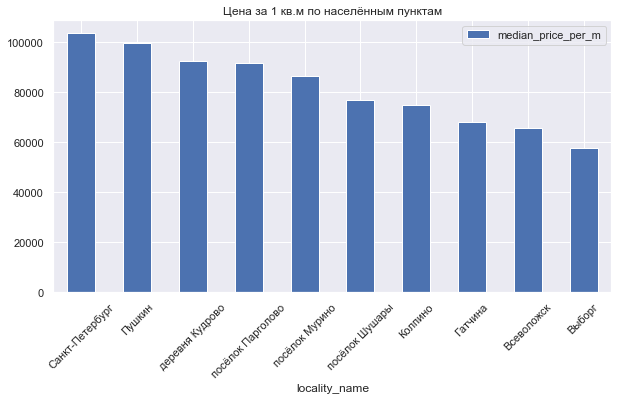

In [49]:
# Выделим 10 населённых пунктов с наибольшим числом объявлений:
big_data = (good_data
     .pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count','median'])
     .sort_values(by=('count', 'price_per_meter'), ascending=False)
     .head(10)
)

big_data = big_data.reset_index()
big_data.columns = ['locality_name', 'count', 'median_price_per_m']
big_data.sort_values(by='median_price_per_m', ascending=False, inplace=True)

display(big_data)

big_data.plot(kind='bar', x='locality_name', y='median_price_per_m', grid=True, title='Цена за 1 кв.м по населённым пунктам', figsize=(10,5))
plt.xticks(rotation=45)
plt.show()

### Исследование стоимости на недвижимость по населённым пунктам. Вывод

Cамое дорогое жильё cреди населённых пунктов с наибольшим числом объявлений находится в Санкт-Петербурге и Пушкине. Замыкают десятку Всеволжск и Выборг.

### [8. Исследование объектов в Санкт-Петербурге](#plan) <a id="st8"></a> 

Коэффициент корреляции Пирсона: -0.34228714435868784


,last_price
distance_to_center,
0.0,7200000.0
1.0,8900000.0
2.0,8775000.0
3.0,7475000.0
4.0,7650000.0
5.0,8183000.0
6.0,7400000.0
7.0,6725000.0
8.0,6450000.0


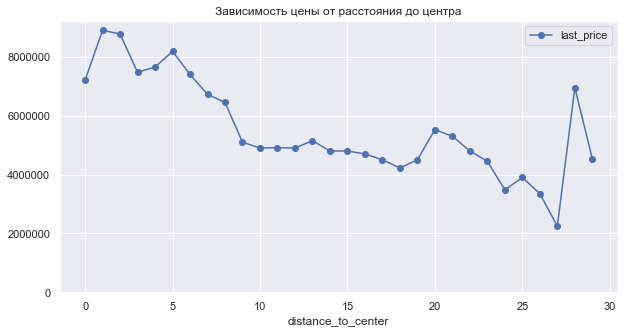

In [50]:
# Изучим предложения в Санкт-Петербурге. Выясним, какая область входит в центр. 
peter_data = good_data.query('locality_name == "Санкт-Петербург"')

# Добавим поле с расстоянием до центра в километрах:
peter_data['distance_to_center'] = (peter_data['cityCenters_nearest'] / 1000).apply(lambda x: round(x, 0))
#display(peter_data[['cityCenters_nearest', 'distance_to_center']].sample(10))

# Строим график зависимости цены от расстояния до центра:
price_relation(peter_data, 'distance_to_center', 'o-', 1, 0, 'Зависимость цены от расстояния до центра')

#Посмотрим на сводную таблицу графика и определим точку перелома:
display(peter_data.pivot_table(index='distance_to_center', values='last_price', aggfunc='median'))

На графике видно, что начиная с 9-ти километров и дальше цена теряет чувствутельность к расстоянию до центра.
Т.е. центральная зона для Санкт-Перербурга ограничена радиусом в 9 км.

#### [8.1 Анализ параметров квартир в центральной области Санкт-Петербурга](#plan) <a id="st8_1"></a> 

count    2653.000000
mean       63.253513
std        22.257272
min        12.000000
25%        45.000000
50%        60.400000
75%        80.000000
max       114.300000
Name: total_area, dtype: float64

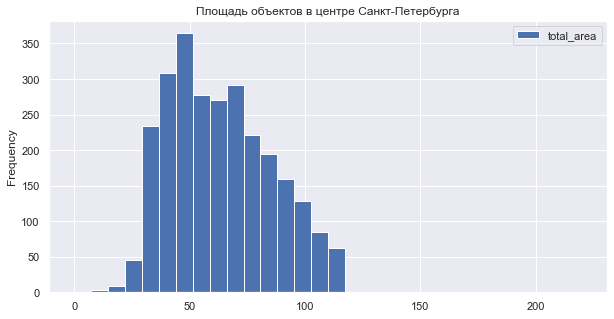

In [51]:
# Проанализируем предложения в центре Санкт-Петербурга:
peter_data_center = peter_data.query('distance_to_center < 10') 
#peter_data_center.info()

# Рассмотрим распределение площади объектов в центре Санкт-Перербурга:
hist_display(peter_data_center, 'total_area', 'Площадь объектов в центре Санкт-Петербурга')
#display('По всему Санкт-Петербургу:', peter_data['total_area'].describe())

Средняя площадь объектов по центру Санкт-Петербурга: 63 кв.м., медиана 60 кв.м., что приблизительно на 20% больше, чем по городу в целом.

count    2.653000e+03
mean     8.199595e+06
std      4.741486e+06
min      1.219000e+04
25%      5.200000e+06
50%      6.990000e+06
75%      9.610305e+06
max      5.000000e+07
Name: last_price, dtype: float64

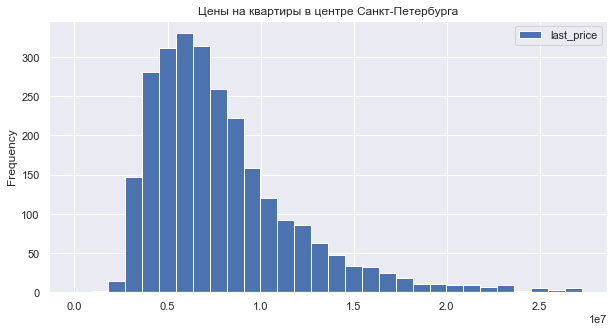

In [52]:
# Рассмотрим распределение цен на квартиры в центре Санкт-Перербурга:
hist_display(peter_data_center, 'last_price', 'Цены на квартиры в центре Санкт-Петербурга')
#display('По всему Санкт-Петербургу:', peter_data['last_price'].describe())

Средняя цена квартиры в центре Санкт-Петербурга ~8.2 млн.р., медиана ~7 млн, что почти в 1.5 раза выше значений по всему городу.

count    2653.000000
mean        2.159065
std         0.915114
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

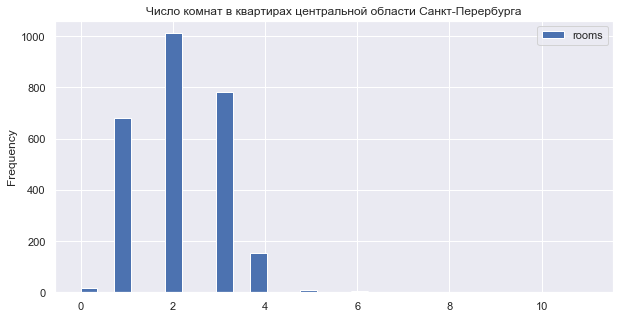

In [53]:
# Рассмотрим распределение цен на квартиры в центре Санкт-Перербурга:
hist_display(peter_data_center, 'rooms', 'Число комнат в квартирах центральной области Санкт-Перербурга')
#display('По всему Санкт-Петербургу:', peter_data['rooms'].describe())

Среднее количество комнат по центру Санкт-Петербурга - 2.2, медиана - 2, что практически совпадает со значениями по всей базе.

count    2653.000000
mean        2.760594
std         0.179337
min         2.400000
25%         2.600000
50%         2.730000
75%         3.000000
max         3.050000
Name: ceiling_height, dtype: float64

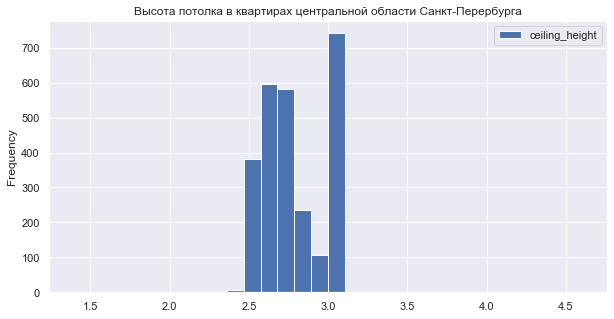

In [54]:
# Рассмотрим распределение высоты потолка в квартирах центральной области Санкт-Перербурга:
hist_display(peter_data_center, 'ceiling_height', 'Высота потолка в квартирах центральной области Санкт-Перербурга')
#display('По всему Санкт-Петербургу:', peter_data['ceiling_height'].describe())

Средняя высота потолка по центру Санкт-Петербурга - 2.8 м, медиана - 2.7 м, что чуть больше показателей по всему городу. На гистограмме видно, что в центре высокие потолки (>= 3 м) всречаются гораздо чаще, чем по всему городу.

#### [8.2 Исследование зависимости цены от других параметров в центральной области Санкт-Петербурга](#plan) <a id="st8_2"></a> 

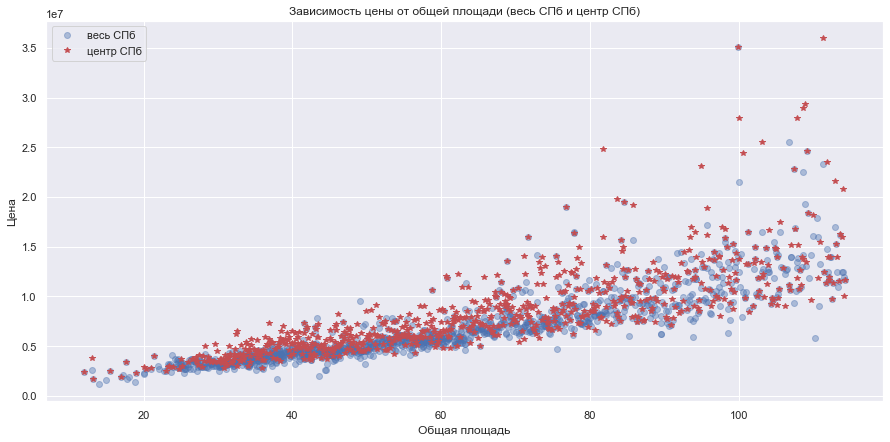

Коэффициент корреляции Пирсона (центр СПб): 0.6770740381075997
Коэффициент корреляции Пирсона (весь СПб): 0.7461933112656001


In [55]:
# Рассмотрим зависимость цены квартиры в центре города от общей площади:
plt.figure(figsize=(15,7))
plt.title('Зависимость цены от общей площади (весь СПб и центр СПб)')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.plot(peter_data.pivot_table(index='total_area', values='last_price', aggfunc='median'), 'o', alpha=0.4, label='весь СПб')
plt.plot(peter_data_center.pivot_table(index='total_area', values='last_price', aggfunc='median'), 'r*', alpha=1, label='центр СПб')
plt.legend(loc="upper left")
plt.show()

print('Коэффициент корреляции Пирсона (центр СПб):', peter_data_center['last_price'].corr(peter_data_center['total_area']))
print('Коэффициент корреляции Пирсона (весь СПб):', peter_data['last_price'].corr(peter_data['total_area']))

Цена на квартиры в центральной области по-прежнему зависит от площади, но чуть слабее, чем по городу в целом.

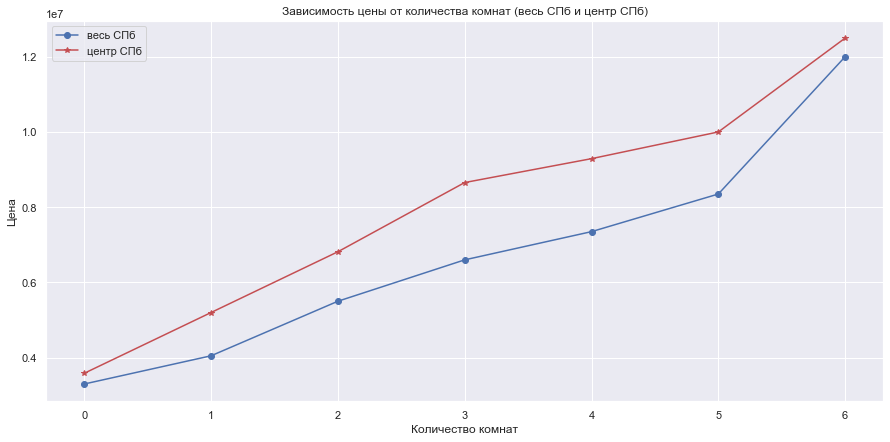

Коэффициент корреляции Пирсона (центр СПб): 0.3571420745082087
Коэффициент корреляции Пирсона (весь СПб): 0.42379615150796646


In [56]:
# Рассмотрим зависимость цены квартиры в центре города от количества комнат:
plt.figure(figsize=(15,7))
plt.title('Зависимость цены от количества комнат (весь СПб и центр СПб)')
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.plot(peter_data.pivot_table(index='rooms', values='last_price', aggfunc='median'), 'o', linestyle='solid', label='весь СПб')
plt.plot(peter_data_center.pivot_table(index='rooms', values='last_price', aggfunc='median'), 'r*', linestyle='solid', label='центр СПб')
plt.legend(loc="upper left")
plt.show()

print('Коэффициент корреляции Пирсона (центр СПб):', peter_data_center['last_price'].corr(peter_data_center['rooms']))
print('Коэффициент корреляции Пирсона (весь СПб):', peter_data['last_price'].corr(peter_data['rooms']))

Связь между ценой и количеством комнат в центре меньше, чем по городу в целом. Зависимость слабая.

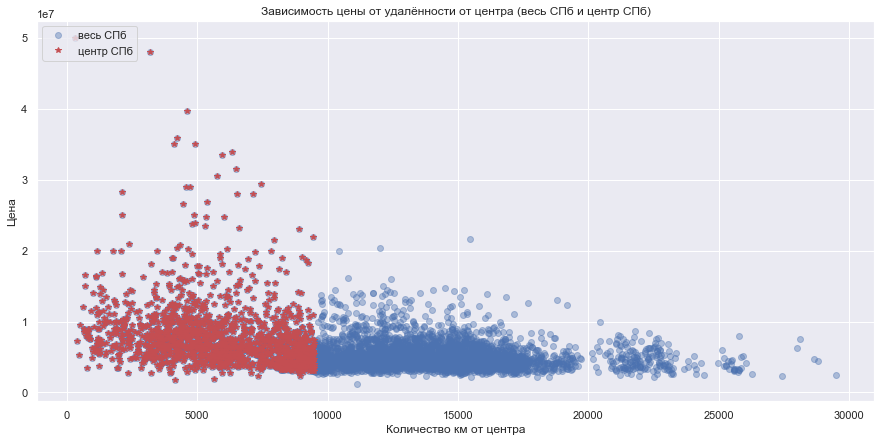

Коэффициент корреляции Пирсона (центр СПб): -0.20949551899163402
Коэффициент корреляции Пирсона (весь СПб): -0.341039671083119


In [57]:
# Рассмотрим зависимость цены квартиры в центре СПб от удалённости от центра:
plt.figure(figsize=(15,7))
plt.title('Зависимость цены от удалённости от центра (весь СПб и центр СПб)')
plt.xlabel('Количество км от центра')
plt.ylabel('Цена')
plt.plot(peter_data.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='median'), 'o', alpha=0.4, label='весь СПб')
plt.plot(peter_data_center.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='median'), 'r*', alpha=1, label='центр СПб')
plt.legend(loc="upper left")
plt.show()

print('Коэффициент корреляции Пирсона (центр СПб):', peter_data_center['last_price'].corr(peter_data_center['cityCenters_nearest']))
print('Коэффициент корреляции Пирсона (весь СПб):', peter_data['last_price'].corr(peter_data['cityCenters_nearest']))

Удалённость от центра не влияет на стоимость квартиры - как по всему городу, так и по центральной области.

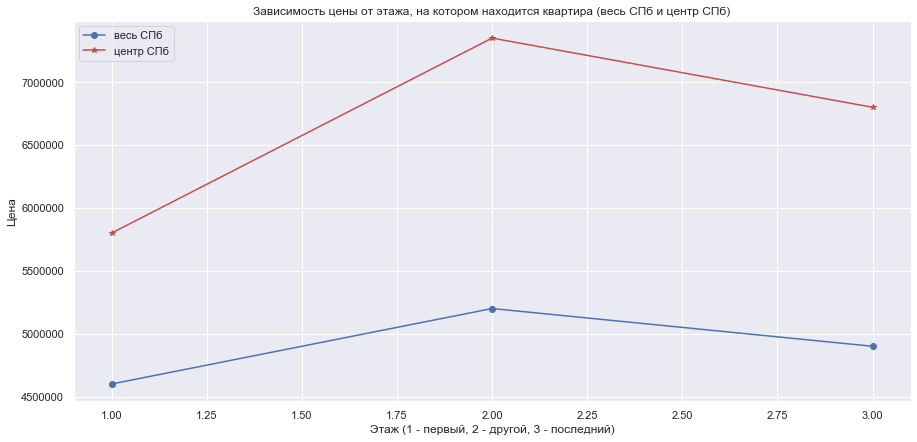

Коэффициент корреляции Пирсона (центр СПб): 0.05150622950185461
Коэффициент корреляции Пирсона (весь СПб): 0.04506022059399735


In [58]:
# Рассмотрим зависимость цены квартиры в центре города от этажа, на котором она находится:
plt.figure(figsize=(15,7))
plt.title('Зависимость цены от этажа, на котором находится квартира (весь СПб и центр СПб)')
plt.xlabel('Этаж (1 - первый, 2 - другой, 3 - последний)')
plt.ylabel('Цена')
plt.plot(peter_data.pivot_table(index='floor_location_int', values='last_price', aggfunc='median'), 'o', linestyle='solid', label='весь СПб')
plt.plot(peter_data_center.pivot_table(index='floor_location_int', values='last_price', aggfunc='median'), 'r*', linestyle='solid', label='центр СПб')
plt.legend(loc="upper left")
plt.show()

print('Коэффициент корреляции Пирсона (центр СПб):', peter_data_center['last_price'].corr(peter_data_center['floor_location_int']))
print('Коэффициент корреляции Пирсона (весь СПб):', peter_data['last_price'].corr(peter_data['floor_location_int']))

Зависимость цены от расположения этажа не обнаружена и для центральной области СПб.

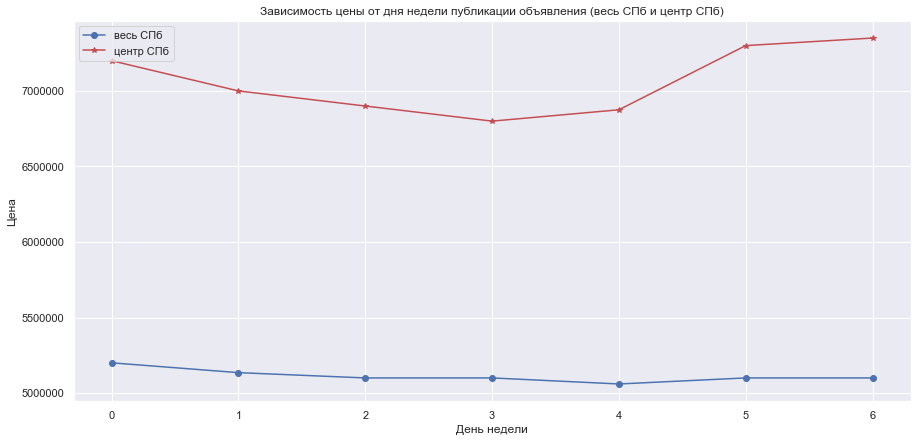

Коэффициент корреляции Пирсона - День недели - (центр СПб): -0.01608296095362841
Коэффициент корреляции Пирсона - День недели - (весь СПб): -0.00969250581331942


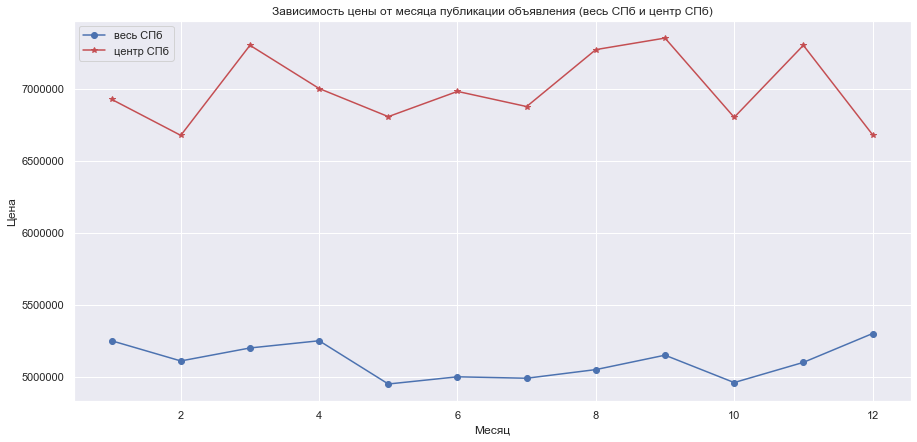

Коэффициент корреляции Пирсона - Месяц - (центр СПб): -0.001160262289187013
Коэффициент корреляции Пирсона - Месяц - (весь СПб): -0.0105415647893805


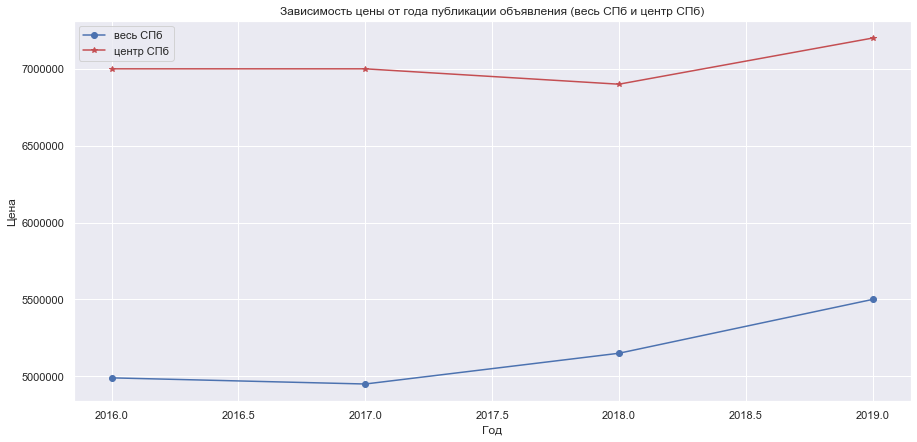

Коэффициент корреляции Пирсона - Год - (центр СПб): -0.00498492464738156
Коэффициент корреляции Пирсона - Год - (весь СПб): 0.03873238104167561


In [59]:
# Рассмотрим зависимость цены квартиры в центре города от даты публикации объявления:
def price_date_relation(param, title, xlabel):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Цена')
    plt.plot(peter_data.pivot_table(index=param, values='last_price', aggfunc='median'), 'o', linestyle='solid', label='весь СПб')
    plt.plot(peter_data_center.pivot_table(index=param, values='last_price', aggfunc='median'), 'r*', linestyle='solid', label='центр СПб')
    plt.legend(loc="upper left")
    plt.show()
    print('Коэффициент корреляции Пирсона -', xlabel,'- (центр СПб):', peter_data_center['last_price'].corr(peter_data_center[param]))
    print('Коэффициент корреляции Пирсона -', xlabel,'- (весь СПб):', peter_data['last_price'].corr(peter_data[param]))

# День недели:
price_date_relation('weekday', 'Зависимость цены от дня недели публикации объявления (весь СПб и центр СПб)', 'День недели')

# Месяц:
price_date_relation('month', 'Зависимость цены от месяца публикации объявления (весь СПб и центр СПб)', 'Месяц')

# Год:
price_date_relation('year', 'Зависимость цены от года публикации объявления (весь СПб и центр СПб)', 'Год')

Цена квартиры в центре Санкт-Петербурга, так же, как и по всей базе, не зависит от дня недели/месяца/года публикации объявления о продаже.

### Исследование объектов в Санкт-Петербурге. Вывод

#### Рассмотрели следующие параметры недвижимости по всему Санкт-Петербургу и отдельно по его центральной области:

- Средняя площадь объектов по центру Санкт-Петербурга: 63 кв.м., медиана: 60 кв.м., что приблизительно на 20% больше, чем по городу в целом.
- Средняя цена квартиры в центре Санкт-Петербурга ~8.2 млн.р., медиана ~7 млн, что более, чем в 1.5 раза выше значений по всему городу.
- Среднее количество комнат по центру Санкт-Петербурга - 2.2, медиана - 2, что практически совпадает с общими значениями по городу.
- Средняя высота потолка по центру Санкт-Петербурга - 2.8 м, медиана - 2.7 м, что чуть больше показателей по городу. На гистограмме видно, что в центре высокие потолки (>= 3 м) всречаются гораздо чаще, чем по всему городу.

#### Исследовали зависимость цены на недвижимость по центральной области Санкт-Петербурга и по городу в целом:

- Цена на квартиры в центральной области по-прежнему зависит от площади, но чуть слабее, чем по городу в целом.
- Связь между ценой и количеством комнат в центре меньше, чем по городу в целом. Зависимость слабая.
- Зависимость цены от расположения этажа не обнаружена как для центральной области СПб, так и в целом по городу.
- Удалённость от центра не влияет на стоимость квартиры - как по всему городу, так и по центральной области.
- Цена квартиры в центре Санкт-Петербурга, так же, как и по всей базе, не зависит от дня недели/месяца/года публикации объявления о продаже.

В центре Санкт-Петербурга сконцентрирована самая дорогая недвижимость. Чаще, чем по базе в целом, встречаются высокие потолки и большая площадь квартир.

### [9. Общий вывод](#plan) <a id="st9"></a> 

#### Рассмотрели основные параметры недвижимости по всей базе:

- Средняя площадь объектов: ~60 кв.м., медиана: 52 кв.м. Большинство объектов имеют площадь от 20м до 150м.
- Средняя стоимость квартиры: около 6.5 млн, медиана: 4.5 млн. Только 3% объектов имеют цену более 20 млн рублей.
- Большинство объектов имеют от 1 до 3 комнат. Среднее количество комнат по всей база совпадает с медианой - 2 шт. В выгрузке всего 2.2% объявлений с количеством комнат более 4-x.
- Медиана высоты потолка: 2.65м. Только 1.4% объявлений имеют высоту потолка менее 2.3 или более 3.5 метров.
- Гистограмма времени продажи квартиры имеет длинный хвост, поэтому среднее значение больше медианного почти в 2 раза. Опираясь на квартили, можно сказать, что квартира продалась быстро, если сделка закрылась за 45 дней и меньше. И, наоборот, долго, если объявление висело дольше 230 дней.

#### Выявили и исключили из рассмотрения редкие и выбивающиеся значения - всего 3565 объявлений:

- объекты площадью менее 12 или более 114.5 кв.м.
- объекты с количеством комнат более 6-ти.
- объекты с высотой потолка менее 2.25 или более 3.05 м.
- объекты, размещённые в базе ранее 2016 года.

####  Исследовали зависимость цены от других параметров:

- Установлена зависимость цены от общей площади объекта (коэфф. корреляции: 0.68). При этом существенный разброс наблюдается среди квартир с большой площадью.
- Связь цены с количеством комнат не сильна (коэфф. корреляции: 0.39). Коэффициент положительный, т.е. при увеличении числа комнат стоимость в целом растёт, но зависимость слабая.
- Связь цены с удалённостью объекта от центра для всей базы в целом не обнаружена (коэфф. корреляции: -0.31).
- Связь цены с этажом, на котором находится квартира, так же не обнаружена (коэфф. корреляции: 0.13).
- Цена так же не зависит от даты публикации объявления - ни от дня недели (коэфф. корр.: -0.01), ни от месяца (коэфф. корр: -0.004), ни от года (коэфф. корр.: 0.02)

####  Исследовали стоимость на недвижимость в популярных населённых пунктах:
Cамое дорогое жильё cреди населённых пунктов с наибольшим числом объявлений находится в Санкт-Петербурге и Пушкине. Замыкают десятку Всеволжск и Выборг.

#### Установили границу центральной области Санкт-Петербурга:
На графике зависимости цены от близости к центру увидели, что начиная с 9-ти километров и дальше цена теряет чувствутельность к расстоянию до центра. Т.е. центральная зона для Санкт-Перербурга ограничена радиусом в 9 км.

#### Рассмотрели следующие параметры недвижимости по всему Санкт-Петербургу и отдельно по его центральной области:
- Средняя площадь объектов по центру Санкт-Петербурга: 63 кв.м., медиана: 60 кв.м., что приблизительно на 20% больше, чем по городу в целом.
- Средняя цена квартиры в центре Санкт-Петербурга ~8.2 млн.р., медиана ~7 млн, что более, чем в 1.5 раза выше значений по всему городу.
- Среднее количество комнат по центру Санкт-Петербурга - 2.2, медиана - 2, что практически совпадает с общими значениями по городу.
- Средняя высота потолка по центру Санкт-Петербурга - 2.8 м, медиана - 2.7 м, что чуть больше показателей по городу. На гистограмме видно, что в центре высокие потолки (>= 3 м) всречаются гораздо чаще, чем по всему городу.

#### Исследовали зависимость цены на недвижимость по центральной области Санкт-Петербурга и по городу в целом:
- Цена на квартиры в центральной области прямо зависит от площади, но чуть слабее, чем по городу в целом.
- Связь между ценой и количеством комнат в центре меньше, чем по городу в целом. Зависимость слабая.
- Зависимость цены от расположения этажа не обнаружена как для центральной области СПб, так и в целом по городу.
- Удалённость от центра не влияет на стоимость квартиры - как по всему городу, так и по центральной области.
- Цена квартиры в центре Санкт-Петербурга, так же, как и по всей базе, не зависит от дня недели/месяца/года публикации объявления о продаже.

В центре Санкт-Петербурга сконцентрирована самая дорогая недвижимость. Чаще, чем по базе в целом, встречаются высокие потолки и большая площадь квартир.

In [60]:
# Таблица, иллюстрирующая зависимость стоимости квартиры от её параметров (коэффициенты корреляции):
data = {'Площадь' : [0.69, 0.77, 0.68],
        'Число комнат' : [0.39, 0.42, 0.38],
        'Удалённость от центра' : [-0.31, -0.34, -0.21],
        'Расположение этажа' : [0.03, 0.04, 0.05],
        'День публикации' : [-0.01, -0.01, -0.02],
        'Месяц публикации' : [-0.004, -0.01, -0.001],
        'Год публикации' : [0.03, 0.04, -0.005],}
frame = pd.DataFrame(data, index=['Вся база', 'Санкт-Петербург', 'центр Санкт-Петербурга'])
print('Зависимость стоимости квартиры от её параметров:')
display(frame)

Зависимость стоимости квартиры от её параметров:


,Площадь,Число комнат,Удалённость от центра,Расположение этажа,День публикации,Месяц публикации,Год публикации
Вся база,0.69,0.39,-0.31,0.03,-0.01,-0.004,0.030
Санкт-Петербург,0.77,0.42,-0.34,0.04,-0.01,-0.010,0.040
центр Санкт-Петербурга,0.68,0.38,-0.21,0.05,-0.02,-0.001,-0.005


В таблице приведены коэффициенты корреляции Пирсона, отражающие зависимость цены объекта от его параметров.

Итак, стоимость квартиры зависит от:
- **Общей площади** (в центре чуть сильнее, чем по городу в целом).
- Числа комнат (хотя связь довольно слаба). Вероятно, количество комнат само по себе зависит от площади, ведь на большой площади и комнат больше. Таким образом, выявленная связь ещё раз подтверждает зависимость цены от общей площади квартиры.